In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision
import os
import pandas as pd
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from skimage import io

import warnings
warnings.filterwarnings("ignore")

Veriyi Dahil Etme

In [9]:
class veri(Dataset): #dataset classı pytorch un veriyi eklemek için kullandırttığı bir classdır.
    def __init__(self, csv_file, root_dir, transform=None): #csv_file fotograflarımızın adreslerinin yer aldığı dosyadır onun pathini vermemiz gerekiyor. root_dir fotograflarımızın oldugu klasörün adresidir
        self.annotations=pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
    def __len__(self):
        return len(self.annotations)
    def __getitem__(self, index):
       img_path=os.path.join(self.root_dir,self.annotations.iloc[index,0])
       image=io.imread(img_path)
       y_label=torch.tensor(int(self.annotations.iloc[index,1]))
       
       if self.transform:
              image=self.transform(image)
              return (image,y_label)

Veriyi Hazırlama

In [10]:
dataset=veri(csv_file="D:\\udemy_data\\f1_classification\\f111.csv",root_dir="D:\\udemy_data\\f1_classification",
transform=torchvision.transforms.Compose([ #compose metodu birden fazla transform işlemini tek seferde yapmamıza olanak tanır.
    transforms.ToTensor(), #tensore cevirmemizi sağlar verimizi
    transforms.Resize(size=(28,28)),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
]))

Veri Ön İşleme

In [11]:
train_set,test_set=torch.utils.data.random_split(dataset,[200,79]) # verimizin 200 ü train geri kalan 79 tanesi test için ayrıldı
train_loader=DataLoader(dataset=train_set,batch_size=1,shuffle=False)
test_loader=DataLoader(dataset=test_set,batch_size=1,shuffle=False)

Veriyi Görselleştirme

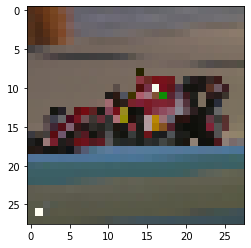

Ferrari
torch.Size([1, 3, 28, 28])


In [12]:
import matplotlib.pyplot as plt
import numpy as np
batch_size=1
classes=["Ferrari","Mclaren","Mercedes","Redbull"]

def imshow(img):
    img=img/2+0.5
    npimg=img.numpy()
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.show()
dataiter=iter(train_loader)
images,labels=dataiter.next()
imshow(torchvision.utils.make_grid(images))
print("".join('%5s' % classes[labels[j]] for j in range(batch_size)))
print(images.size())



Model Mimarisini Oluşturma

In [13]:
class Net(nn.Module): #model yapısı class içinde oluşturulur ilk 3 satır pytochda class için temel tanımlamalardır.
    def __init__(self):
        super(Net,self).__init__()
        #conv katmanları:
        self.conv1=nn.Conv2d(in_channels=3,out_channels=4,kernel_size=(5,5)) #giriş kanalı, çıkış kanalı ve kernel size ı tanımladık atride(adım) gibi tanımlamaları default değerde bıraktık.
        self.conv2=nn.Conv2d(in_channels=4,out_channels=8,kernel_size=(3,3))
        self.conv3=nn.Conv2d(in_channels=8,out_channels=16,kernel_size=(2,2))
        self.conv4=nn.Conv2d(in_channels=16,out_channels=32,kernel_size=(2,2))
        #max pooling katmanı:

        self.max=nn.MaxPool2d(kernel_size=(2,2)) # bu katman her conv dan sonra çalışıcak bağlama kısmında belirtiyoruz. Buraya birden fazla maxpool fonksiyonu tanımlayıp bağlama fonksiyonunda onlarıda kullanabiliriz.

        #aktivasyon fonksiyonu:
        self.func=nn.ELU()

        #fully connected laerımız: ("tensorflowda dense diye geçiyor")
        self.fc1=nn.Linear(in_features=32,out_features=50) #conv katmanından en son 32 kanal çıktıgı için girişi 32 ile başlattık.
        self.fc2=nn.Linear(in_features=50,out_features=50)
        self.fc3=nn.Linear(in_features=50,out_features=100)
        self.fc4=nn.Linear(in_features=100,out_features=4) # son çıktı katmanımız 4 formula aracı oldugu için 4 çıkışlı yaptık.

    def forward(self,x): # bu fonksiyon bağlama fonksiyonudur oluşturdugumuz katmanlar birbirine bağlı değil bu fonksiyon ile bağlama işlmeini geçekleştiriyoruz.
         x=self.conv1(x) #conv katmanının çıkışını aktivasyon fonksiyonuna onuda maxpool a gönderiyoruz sonuncu conv katmanının çıkışında maxpool yok
         x=self.func(x)
         x=self.max(x)

         x=self.conv2(x)
         x=self.func(x)
         x=self.max(x)

         x=self.conv3(x)
         x=self.func(x)
         x=self.max(x)

         x=self.conv4(x)
         x=self.func(x)

         x=x.view(x.size(0),-1) #flatten: düzleştirme işlemi

         x=self.fc1(x)
         x=self.func(x)
         x=self.fc2(x)
         x=self.func(x)
         x=self.fc3(x)
         x=self.func(x)
         x=self.fc4(x)
            
         return x
          


